In [1]:
# general purpose packages
import pandas as pd
import numpy as np
from datetime import datetime
# for model saving and loading
import pickle
import os
import math

# viasualizzation related packages
import matplotlib.pylab as plt
import seaborn as sns
sns.set()

# import graph related packages
import networkx as nx

# Model related packages
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model selection related packages
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import randint

# Classifier Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# summarizing results in a table
from prettytable import PrettyTable

# Configs

In [2]:
print(datetime.now() ,' Started')

sample_size = -1 # set -1 for using full size # -1 or 0.01 etc.
df_train_path = './data/Final_graph_train_features.csv'
df_test_path = './data/Final_graph_test_features.csv'

2019-06-23 16:52:12.700897  Started


# Data

In [3]:
df_train = pd.read_csv(df_train_path, index_col=False)
df_test = pd.read_csv(df_test_path, index_col=False)
print('Shape of train data frame', df_train.shape)
print('Shape of test data frame', df_test.shape)
df_train.head()

Shape of train data frame (100000, 63)
Shape of test data frame (100000, 63)


,src_num_followers,src_num_followees,src_common_nodes_count,src_incoming_edge_weight,src_outgoing_edge_weight,src_weight_sum,src_weight_product,src_liner_sum_1,src_liner_sum_2,dst_num_followers,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,U_DOT,V_DOT,Label
0,1,4,1,0.707107,0.447214,1.154320,0.316228,1.861427,1.601534,8,...,4.849544e-20,3.066836e-09,-1.320418e-12,-3.511876e-07,-1.484744e-12,4.322285e-12,5.413785e-12,4.738274e-25,5.909254e-22,0
1,0,2,0,1.000000,0.577350,1.577350,0.577350,2.577350,2.154701,9,...,0.000000e+00,2.912995e-14,-8.226035e-11,-5.907914e-12,-8.215418e-13,1.031080e-12,5.646996e-15,1.414967e-20,0.000000e+00,0
2,1,2,1,0.707107,0.577350,1.284457,0.408248,1.991564,1.861807,0,...,1.698938e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.614572e-26,0.000000e+00,0
3,1,1,1,0.707107,0.707107,1.414214,0.500000,2.121320,2.121320,2,...,-1.525110e-21,6.639933e-19,-2.337091e-16,-8.949695e-15,-3.956764e-13,1.228825e-18,7.163667e-21,1.865929e-33,5.915392e-34,0
4,46,89,15,0.145865,0.105409,0.251274,0.015376,0.397139,0.356684,111,...,2.358748e-14,-8.379303e-11,-7.496258e-02,-9.565510e-10,-3.057344e-10,1.883535e-07,4.559034e-14,2.774752e-03,2.623718e-03,1


In [4]:
# Sample the data frame if opted
if sample_size > 0:
    print('Sample from the data frame is taken !!!')
    # sample train dataset
    df_train = df_train.sample(frac=sample_size)
    df_train = df_train.reset_index(drop=False)
    # sample test dataset
    df_test = df_test.sample(frac=sample_size)
    df_test = df_test.reset_index(drop=False)

In [5]:
# get train features, labels separately
X_train = df_train.drop(['Label'], axis=1)
y_train = df_train['Label']

# get test features, labels separately
X_test = df_test.drop(['Label'], axis=1)
y_test = df_test['Label']

# UTIL Functions

In [6]:
def get_confusion_matrix(actual_list, predicted_list, title_suffix=str()):
    """
    This function plots the confusion matrix given ground truth and predicted
    """
    
    conf_matrix = confusion_matrix(actual_list, predicted_list, labels=[0, 1])
    
    col_names = ['Not Recommend', 'Recommend']
    conf_df = pd.DataFrame(conf_matrix, columns=col_names)
    conf_df.index = col_names
    
    # plot confusion matrix
    sns.heatmap(conf_df, annot=True, annot_kws={'size': 16}, fmt='g', cmap='YlGnBu',
                   cbar_kws={'label': 'prediction_count', 'format':'%d'})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix -' + title_suffix)
    plt.show()
    
    return conf_df

In [7]:
def get_precision_recall_matrix(conf_matrix, title_suffix=str()):
    
    # compute precision matrix
    precision_matrix = conf_matrix.div(conf_matrix.sum(axis=0), axis=1) * 100.0
    
    # compute recall matrix
    recall_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0) * 100.0
    
    # plot both the matrices
    
    # plot precision matrix
    sns.heatmap(precision_matrix, annot=True, annot_kws={'size': 16}, fmt='.4f', cmap='YlGnBu',
                   cbar_kws={'label': 'percentage', 'format':'%.2f'})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Precision Matrix -' + title_suffix)
    plt.show()
    
    # plot recall matrix
    sns.heatmap(recall_matrix, annot=True, annot_kws={'size': 16}, fmt='.4f', cmap='YlGnBu',
                   cbar_kws={'label': 'percentage', 'format':'%.2f'})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Recall Matrix -' + title_suffix)
    plt.show()
    
    # return as a tuple
    return (precision_matrix, recall_matrix,)

In [8]:
def get_classification_report(actual, predicted, title_suffix=str()):
    
    # set class labels and its corresponding name
    class_labels_list = [0, 1]
    col_names = ['Not Recommend', 'Recommend']
    
    # compute performance df
    eval_matrix = precision_recall_fscore_support(actual, predicted, 
                                                  labels=class_labels_list)
    
    eval_df = pd.DataFrame(list(eval_matrix), columns=class_labels_list)
    eval_df.index = ['Precision', 'Recall', 'Fscore', 'Support']
    eval_df.columns = col_names
    
    
    # normalize the performace df
    eval_df_normed = eval_df * 100.0
    eval_df_normed.loc['Support', col_names] /= eval_df_normed.loc['Support', col_names].sum()
    eval_df_normed.iloc[3:4, :] *= 100.0
    
    # plot the classification report
    sns.heatmap(eval_df_normed, annot=True, annot_kws={'size': 16}, fmt='.4f', cmap='YlGnBu',
                   cbar_kws={'label': 'Percentage', 'format':'%.2f'})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    
    plt.xlabel('Classes')
    plt.ylabel('Metrics')
    plt.title('Classification Report -' + title_suffix)
    plt.show()
    
    return eval_df_normed

In [9]:
def evaluate_model(model, X, y):
    
    # get prediction and its probability
    predicted_labels = model.predict(X)
    predicted_probs = model.predict_proba(X)
     
    # get confsuion matrix
    conf_matrix = get_confusion_matrix(y, predicted_labels) 
    
    # get precision & recall matrix
    pre_matrix, recall_matrix = get_precision_recall_matrix(conf_matrix)
    
    # get classification report
    clf_report = get_classification_report(y, predicted_labels)
    
    # get the fscore value
    prec_neg, prec_pos = tuple(clf_report.loc['Precision',:])
    fscore_neg, fscore_pos = tuple(clf_report.loc['Fscore',:])
    
    # create table entry tuple
    table_entry = (round(fscore_pos,4),)
    
    return table_entry

# Models

## A) Random Forest Classifier

In [10]:
def get_best_hyperparam_RFClassifier(param_dict, X, y, random_search=False):
    
    # set the scoring function
    final_scorer = 'f1score'
    
    # declare a scoring dictionary
    score_dict = {
        'f1score': make_scorer(score_func=f1_score, greater_is_better=True,
                                     needs_proba=False, needs_threshold=False)
    }
        
    
     #Declare the metric as  'minimization' or 'maximization'
    optimization_dict = {
        'f1score' : 'maximization'
    }
    
    
    # statified kfold split
    cv_data = 3
        
     
    # declare model
    model = RandomForestClassifier()
    
    if random_search:
        search_cv = RandomizedSearchCV(estimator=model, param_distributions=param_dict, 
                                       cv=cv_data, scoring=score_dict, refit=False, 
                                       return_train_score=True, n_iter=20, n_jobs=-1)
        
    else:
        # declare grid search CV object
        search_cv = GridSearchCV(estimator=model, param_grid=param_dict, cv=cv_data,
                                 scoring=score_dict, refit=False, 
                                 return_train_score=True, n_jobs=-1)
    
    # fit to the data
    search_cv.fit(X, y)
    
    
    # get total number of param settings
    param_list = list(param_dict.keys())
    param_field_list = ['param_' + item for item in param_list]
    
    # get list of train metric list
    train_metric_list = ['mean_train_' + item for item in score_dict.keys()]
    # get list of test metric list
    test_metric_list = ['mean_test_' + item for item in score_dict.keys()]
    
    # get number of rows in the search cv data frame
    num_rows = len(search_cv.cv_results_['params'])
        
    # create the grid search info df  
    grid_info_df = pd.DataFrame(search_cv.cv_results_, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['params'] + param_field_list + train_metric_list + \
                       test_metric_list
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
    # process individual metrics
    for metric, optimization in optimization_dict.items():
        if optimization == 'minimization':
            grid_info_df['mean_train_' + metric] *= -1
            grid_info_df['mean_test_' + metric] *= -1
            
    # Find the best hyperparam & its corresponding scores
    if optimization_dict[final_scorer] == 'minimization':
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
    else:
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmax(),:]
        
    # best hyperparam & corresponding scores
    best_hyperparam = best_hyperparam_record['params']
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    if len(param_list) == 1:
        
        # extract individual fiedls
        x_vals = grid_info_df[param_field_list[0]].tolist()
        y_vals_tr = grid_info_df['mean_train_' + final_scorer].tolist()
        y_vals_val = grid_info_df['mean_test_' + final_scorer].tolist()
        
        # plot train, validation performances
        plt.plot(x_vals, y_vals_tr, label='Train', color='r', marker='o', linestyle='-')
        plt.plot(x_vals, y_vals_val, label='Validation', color='b', marker='o', linestyle='-')
        plt.xlabel('Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.legend()
        plt.title('RF Classifier - Hyperparam Train v/s Validation Scores')
        plt.show()
        
        
    # Heatmap plot for pair of hyperparam values  
    elif len(param_list) == 2:
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_train_' + final_scorer , 
                                      fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('RF Classifier - Hyperparams Scores - Train')
        plt.show()
        
        print('\n'*3)
        
        # Test hyperparam
        
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_test_' + final_scorer, fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('RF Classifier - Hyperparams Scores - Validation')
        plt.show()
        
    else:
        print(grid_info_df)
    
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    #best_mse_train = best_hyperparam_record['mean_train_MSE']
    #best_mse_validation = best_hyperparam_record['mean_test_MSE']
    
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score,)
    
    
    return ret_tuple

### 1. Find the best hyperparameter

2019-06-23 16:52:18.758040  Hyperparam Tuning of RF started


/home/nisheel-s/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/nisheel-s/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


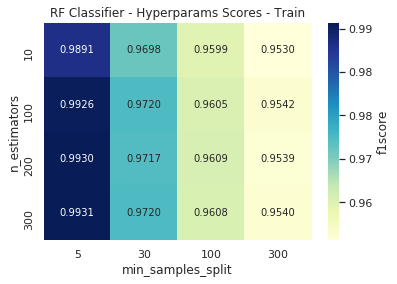

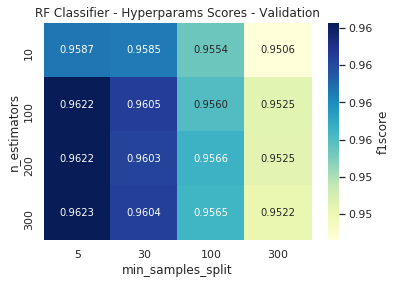

Best hyperparam value:  {'min_samples_split': 5, 'n_estimators': 300} Best Train Score:  0.9930654768512598 Best Validation Score:  0.962261707743909
2019-06-23 16:58:36.690489  Hyperparam Tuning of RF completed


In [11]:
# declare a set of params to search for
"""
param_dict_rf = {'n_estimators' : randint(20,200),
                 'min_samples_split' : randint(30,180),
                 'min_samples_leaf': randint(25,65),
                 'max_depth' : randint(10,15)
                }
"""

param_dict_rf = {'n_estimators' : [10, 100, 200, 300],
                 'min_samples_split' : [5, 30, 100, 300],
                }


print(datetime.now() ,' Hyperparam Tuning of RF started')
hyp_tuned_info_rf = get_best_hyperparam_RFClassifier(param_dict_rf, X_train, y_train, False)
print(datetime.now() ,' Hyperparam Tuning of RF completed')


best_hyp_rf, best_tr_score_rf, best_val_score_rf = hyp_tuned_info_rf

rf_clf = RandomForestClassifier(n_estimators=best_hyp_rf['n_estimators'],
                                min_samples_split=best_hyp_rf['min_samples_split'],
                                #min_samples_leaf=best_hyp_rf['min_samples_leaf'],
                                #max_depth=best_hyp_rf['max_depth'])
                               )

### 2. Train the model with best hyperparameter

In [12]:
# train the model using the best hyperparam obtained
print(datetime.now() ,' Training of RF started')
rf_clf.fit(X_train, y_train)
print(datetime.now() ,' Training of RF completed')

# save model to disk
pickle_out = open("./model/rf_clf.pkl","wb")
pickle.dump(rf_clf, pickle_out)
pickle_out.close()

2019-06-23 16:58:36.701123  Training of RF started
2019-06-23 16:59:43.622639  Training of RF completed


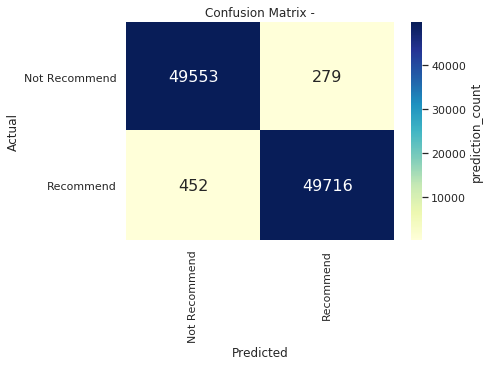

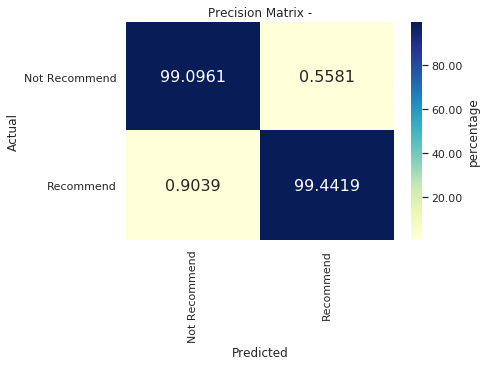

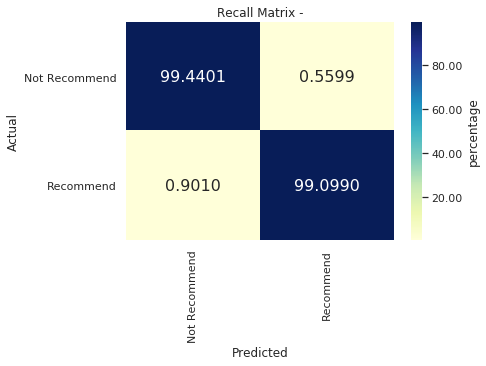

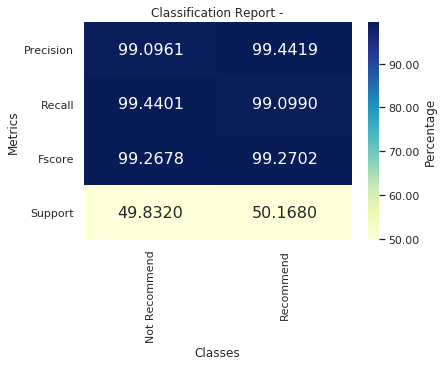

In [13]:
#load model from disk
pickle_in = open("./model/rf_clf.pkl","rb")
rf_clf = pickle.load(pickle_in)
pickle_in.close()

table_entry_rf_train = evaluate_model(rf_clf, X_train, y_train)

### 3. Test the model

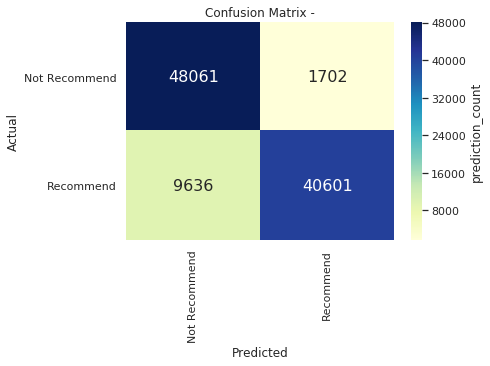

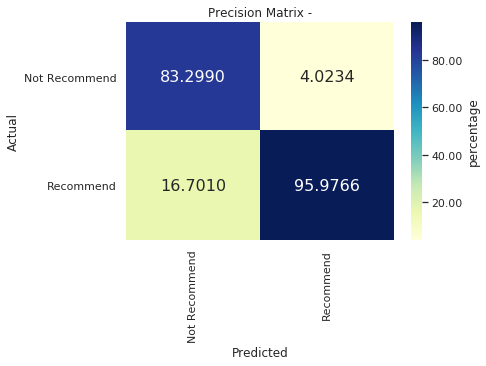

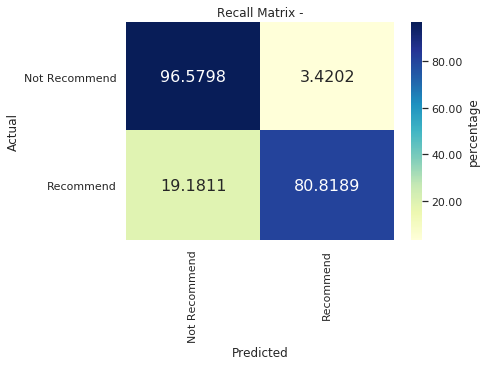

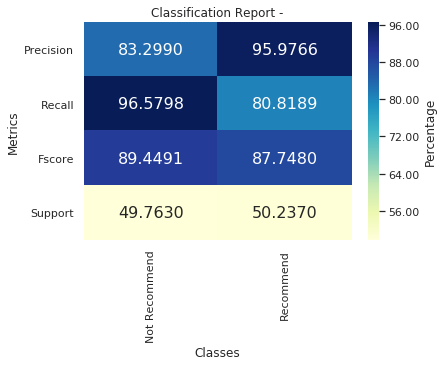

In [14]:
table_entry_rf_test = evaluate_model(rf_clf, X_test, y_test)
best_hyp_rf = '\n'.join(str(best_hyp_rf).split(','))
table_entry_rf = ('RF Classifier', best_hyp_rf,) + table_entry_rf_train + table_entry_rf_test

## Feature Importance

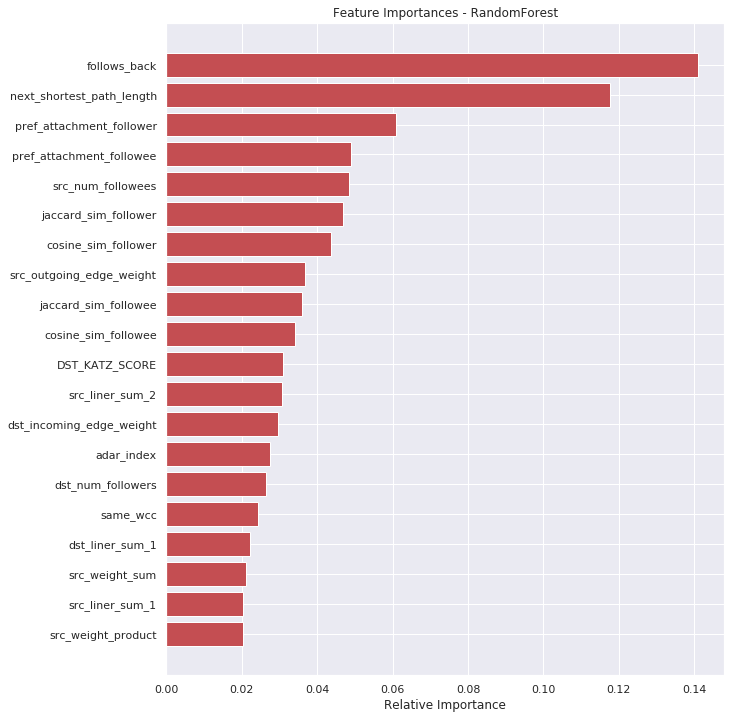

In [15]:
features = X_train.columns.values.tolist()
importances = rf_clf.feature_importances_

indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - RandomForest')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## B) XGB Classifier

In [16]:
def get_best_hyperparam_XGBClassifier(param_dict, X, y, random_search=False):
    
    # set the scoring function
    final_scorer = 'f1score'
    
    # declare a scoring dictionary
    score_dict = {
        'f1score': make_scorer(score_func=f1_score, greater_is_better=True,
                                     needs_proba=False, needs_threshold=False)
    }
        
    
     #Declare the metric as  'minimization' or 'maximization'
    optimization_dict = {
        'f1score' : 'maximization'
    }
    
    
    # statified k fold validation
    cv_data = 3
        
    # declare model
    model = XGBClassifier()
    
    if random_search:
        search_cv = RandomizedSearchCV(estimator=model, param_distributions=param_dict, 
                                       cv=cv_data, scoring=score_dict, refit=False, 
                                       return_train_score=True, n_iter=6, n_jobs=-1)
        
    else:
        # declare grid search CV object
        search_cv = GridSearchCV(estimator=model, param_grid=param_dict, cv=cv_data,
                                 scoring=score_dict, refit=False, 
                                 return_train_score=True, n_jobs=-1)
    
    # fit to the data
    search_cv.fit(X, y)
    
    
    # get total number of param settings
    param_list = list(param_dict.keys())
    param_field_list = ['param_' + item for item in param_list]
    
    # get list of train metric list
    train_metric_list = ['mean_train_' + item for item in score_dict.keys()]
    # get list of test metric list
    test_metric_list = ['mean_test_' + item for item in score_dict.keys()]
    
    # get number of rows in the search cv data frame
    num_rows = len(search_cv.cv_results_['params'])
        
    # create the grid search info df  
    grid_info_df = pd.DataFrame(search_cv.cv_results_, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['params'] + param_field_list + train_metric_list + \
                       test_metric_list
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
    # process individual metrics
    for metric, optimization in optimization_dict.items():
        if optimization == 'minimization':
            grid_info_df['mean_train_' + metric] *= -1
            grid_info_df['mean_test_' + metric] *= -1
            
    # Find the best hyperparam & its corresponding scores
    if optimization_dict[final_scorer] == 'minimization':
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
    else:
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmax(),:]
        
    # best hyperparam & corresponding scores
    best_hyperparam = best_hyperparam_record['params']
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    if len(param_list) == 1:
        
        # extract individual fiedls
        x_vals = grid_info_df[param_field_list[0]].tolist()
        y_vals_tr = grid_info_df['mean_train_' + final_scorer].tolist()
        y_vals_val = grid_info_df['mean_test_' + final_scorer].tolist()
        
        # plot train, validation performances
        plt.plot(x_vals, y_vals_tr, label='Train', color='r', marker='o', linestyle='-')
        plt.plot(x_vals, y_vals_val, label='Validation', color='b', marker='o', linestyle='-')
        plt.xlabel('Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.legend()
        plt.title('XGB Classifier - Hyperparam Train v/s Validation Scores')
        plt.show()
        
        
    # Heatmap plot for pair of hyperparam values  
    elif len(param_list) == 2:
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_train_' + final_scorer , 
                                      fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('XGB Classifier - Hyperparams Scores - Train')
        plt.show()
        
        print('\n'*3)
        
        # Test hyperparam
        
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_test_' + final_scorer, fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('XGB Classifier - Hyperparams Scores - Validation')
        plt.show()
        
    else:
        print(grid_info_df)
    
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    #best_mse_train = best_hyperparam_record['mean_train_MSE']
    #best_mse_validation = best_hyperparam_record['mean_test_MSE']
    
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score,)
    
    
    return ret_tuple

### 1. Find the best hyperparameter

2019-06-23 17:00:06.295206  Hyperparam Tuning of XGB started


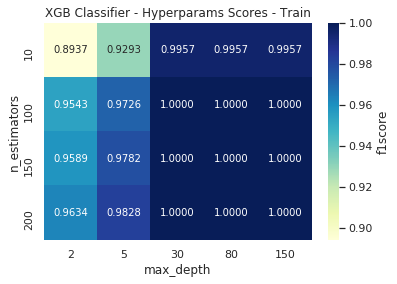

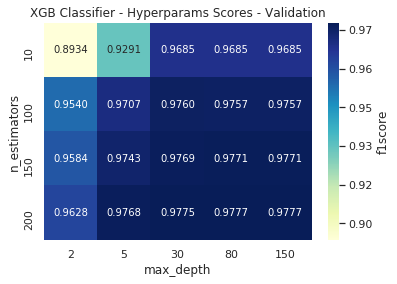

Best hyperparam value:  {'max_depth': 80, 'n_estimators': 200} Best Train Score:  1.0 Best Validation Score:  0.9777049205502226
2019-06-23 17:27:22.942277  Hyperparam Tuning of XGB completed


In [17]:
# declare a set of params to search for
"""
param_dict_xgb = {'n_estimators' : randint(60,200),
                  'learning_rate' : [1e-04, 1e-03, 1e-02, 1e-01, 1e+00],
                  'max_depth' : randint(10,15)
                 }
"""

param_dict_xgb = {'n_estimators' : [10, 100, 150, 200],
                  'max_depth' : [2, 5, 30, 80, 150]
                 }

print(datetime.now() ,' Hyperparam Tuning of XGB started')
hyp_tuned_info_xgb = get_best_hyperparam_XGBClassifier(param_dict_xgb, X_train, y_train, False)
print(datetime.now() ,' Hyperparam Tuning of XGB completed')

best_hyp_xgb, best_tr_score_xgb, best_val_score_xgb = hyp_tuned_info_xgb

xgb_clf = XGBClassifier(n_estimators=best_hyp_xgb['n_estimators'], 
                        max_depth=best_hyp_xgb['max_depth'],
                        #learning_rate=best_hyp_xgb['learning_rate']
                       )

### 2. Train the model with best hyperparameter

In [18]:
# train the model using the best hyperparam obtained
print(datetime.now() ,' Training of XGB started')
xgb_clf.fit(X_train, y_train)
print(datetime.now() ,' Training of XGB completed')

# save model to disk
pickle_out = open("./model/xgb_clf.pkl","wb")
pickle.dump(xgb_clf, pickle_out)
pickle_out.close()

2019-06-23 17:27:22.956185  Training of XGB started
2019-06-23 17:33:19.615081  Training of XGB completed


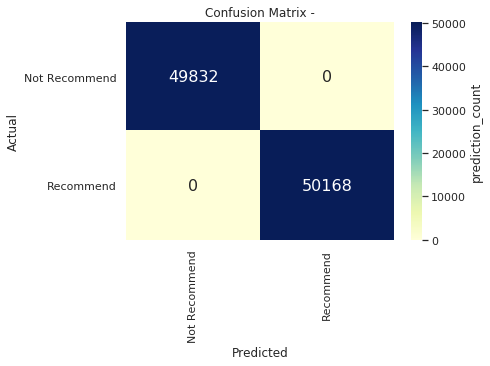

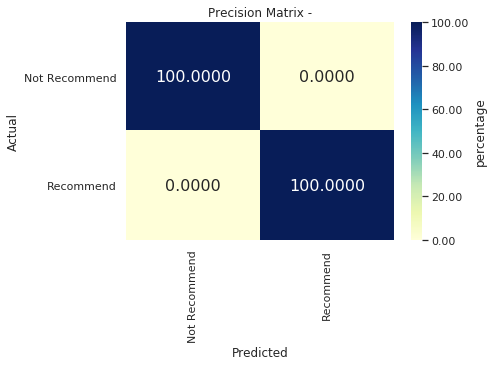

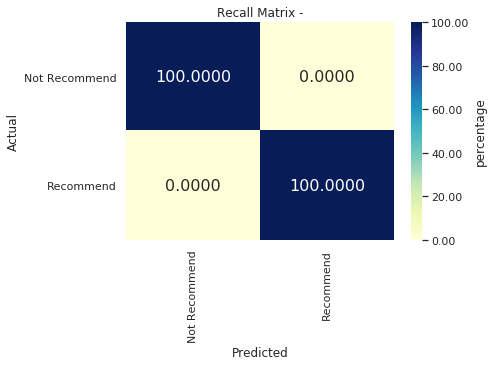

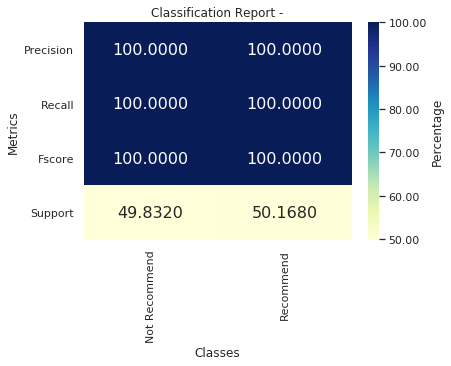

In [19]:
#load model from disk
pickle_in = open("./model/xgb_clf.pkl","rb")
xgb_clf = pickle.load(pickle_in)
pickle_in.close()

table_entry_xgb_train = evaluate_model(xgb_clf, X_train, y_train)

### 3. Test the model

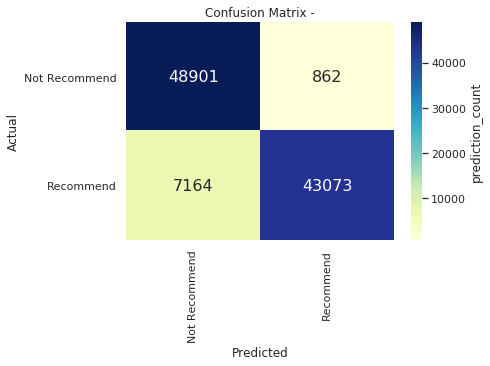

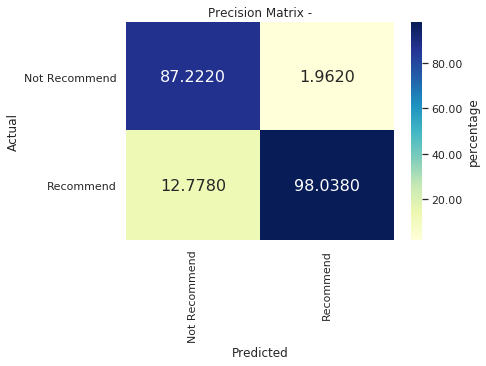

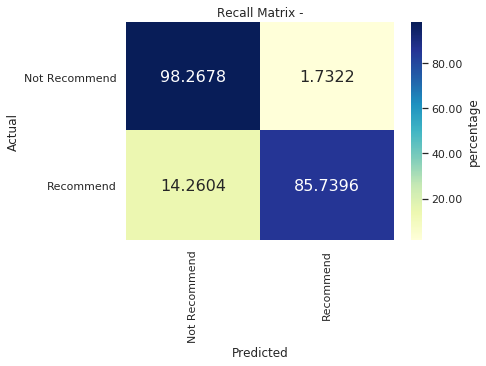

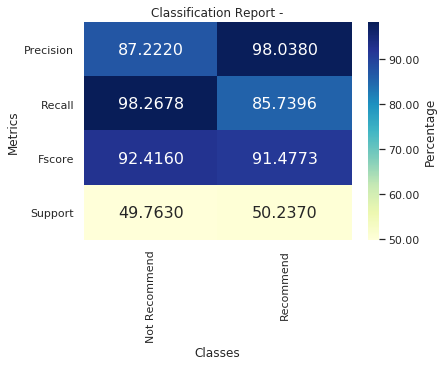

In [20]:
table_entry_xgb_test = evaluate_model(xgb_clf, X_test, y_test)
best_hyp_xgb = '\n'.join(str(best_hyp_xgb).split(','))
table_entry_xgb = ('XGB Classifier', best_hyp_xgb,) + table_entry_xgb_train + table_entry_xgb_test

## Feature Importance

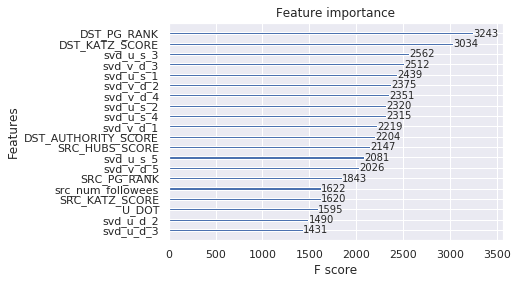

In [21]:
xgb.plot_importance(xgb_clf, height=0.2, max_num_features=20)
plt.show()

# Results Summary

In [22]:
Pret_table = PrettyTable()
Pret_table.field_names = ['Model', 'Hyperparam', 'Train F1_Score(%)', 'Test F1_Score(%)']
Pret_table.title = 'Classification Model Results Summary'

Pret_table.add_row(table_entry_rf)
Pret_table.add_row(table_entry_xgb)
print(Pret_table)

print(datetime.now() ,' Done !!!')

+----------------+-------------------------+-------------------+------------------+
|     Model      |        Hyperparam       | Train F1_Score(%) | Test F1_Score(%) |
+----------------+-------------------------+-------------------+------------------+
| RF Classifier  | {'min_samples_split': 5 |      99.2702      |      87.748      |
|                |   'n_estimators': 300}  |                   |                  |
| XGB Classifier |     {'max_depth': 80    |       100.0       |     91.4773      |
|                |   'n_estimators': 200}  |                   |                  |
+----------------+-------------------------+-------------------+------------------+
2019-06-23 17:33:29.566349  Done !!!


# Procedure Summary

<ul>
<li> Hyperparam tuning is done for RF & XGB </li>
<li> Trained two models RF & XGB on the dataset created </li>
<li> Important features are listed for RF & XGB classifiers</li>
<li> Evaluated both models on the test dataset and compared the performance</li>
</ul>

# Conclusion

<ul>
<li> XGB model (91.47 f1-score) outperformed the RF model (87.74 f1-score)</li>
<li> Both the model showed tendency of overfit, this is more significatnt in random forest model</li>
<li> Feature selection methods can be tried to improve the performace</li>
<li> Page Rank & Katz score are the two most important features for XGB </li>
<li> Follows back & next shorted path are the two most important features for RF </li>
<li> Added engineered feature preferential attachment is identified as the third most important feature for
     random forest </li>
</ul>